In [11]:
%matplotlib inline

from __future__ import print_function
import keras
import numpy as np
import pickle 

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Merge
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import backend as K
from keras.utils import plot_model
from cv2 import imread

from matplotlib import pyplot as plt
from IPython.display import clear_output

from data import getVideoData
from data import getAudioData
from data import getFusionData

## Ploting loss functions

In [12]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [13]:
def getModelArchitecture(input_shape, final_pool):
    cmodel = Sequential()

    #cmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = 'same'))
    cmodel.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = 'same'))
    #cmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cmodel.add(Dropout(0.25))

    cmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    #cmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cmodel.add(Dropout(0.25))

    #cmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    #cmodel.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cmodel.add(Dropout(0.25))

    #cmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    #cmodel.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(final_pool), strides=None, padding='same'))
    cmodel.add(Dropout(0.25))

#    cmodel.add(Flatten())
#    cmodel.add(Dense(32, activation='sigmoid'))
#    cmodel.add(Dropout(0.25))
#    cmodel.add(Dense(2, activation='sigmoid'))

    return cmodel

#testing
getModelArchitecture((224, 224, 3), (28, 28)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 56, 56, 64)        18496     
__________

## Code for building submodels.

In [15]:
def vidMain():
    model = getModelArchitecture((224, 224, 3), (28, 28))
    model = addFCLayers(model)
    model = getTrainedModel(model, dataFactory = getVideoData)

    return model

def audioMain():
    model = getModelArchitecture((199, 257, 3), (25, 33))
    model = addFCLayers(model)
    model = getTrainedModel(model, dataFactory = getAudioData)

## Fusion branch

In [14]:
def fusionBranch(video_branch, audio_branch):

    final = Sequential()
    final.add(Merge([video_branch, audio_branch]))
    #final.add(Dense(512, activation='relu'))
    final.add(Dense(128, activation='relu'))
    final.add(Flatten())
    final.add(Dense(2, activation='softmax'))

    final.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adadelta(),
            #optimizer='adam',
            metrics=['accuracy']
            )
    
    return final

def trainFinal(final):
    print('Getting data...')
    audio_video_data_tuple, label_on_correspondence = getFusionData()
    print('Data ready')

    final.fit(audio_video_data_tuple, label_on_correspondence,
            batch_size=10, epochs=20, verbose=1, callbacks=[plot_losses])

    return final

## Main

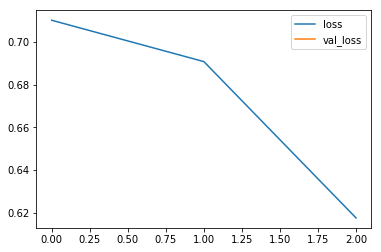

1600/1600 [==============================] - 64s - loss: 0.6175 - acc: 0.6719    
Epoch 4/20
 260/1600 [===>..........................] - ETA: 53s - loss: 0.5360 - acc: 0.7500

KeyboardInterrupt: 

In [16]:
def fusedMain():
    vmodel = getModelArchitecture((224, 224, 3), (28, 28))
    amodel = getModelArchitecture((199, 257, 3), (25, 33))
    
    f = fusionBranch(vmodel, amodel)
    f = trainFinal(f)

    return f

if __name__ == '__main__':
    fusedMain()

### Test code below for sub-model training.

In [ ]:
def addFCLayers(cmodel):

    cmodel.add(Flatten())
    cmodel.add(Dense(32, activation='sigmoid'))
    cmodel.add(Dropout(0.25))
    cmodel.add(Dense(2, activation='sigmoid'))

    return cmodel
    

def trainModel(model, x_train, y_train, x_test, y_test):
    model.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

    model.fit(x_train, y_train, 
            batch_size=8,
            verbose=1,
            validation_data=(x_test, y_test))

    return model